In [1]:
import duckdb
import itertools
import pandas as pd
import numpy as np
from collections import Counter
from sklearn.decomposition import NMF
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances

from sklearn import cluster, datasets, mixture

import matplotlib as mpl
from scipy import linalg

from matplotlib import pyplot as plt
import random
from collections import Counter


pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

## Toy data with clusters

In [2]:
blobs = datasets.make_blobs(n_samples=1500, random_state=8)
X,y = blobs

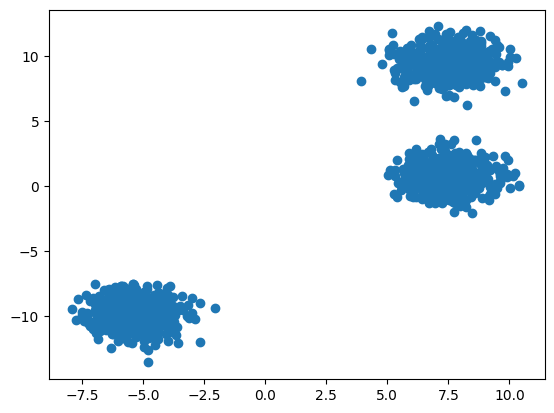

In [3]:
plt.scatter(X[:, 0], X[:, 1])

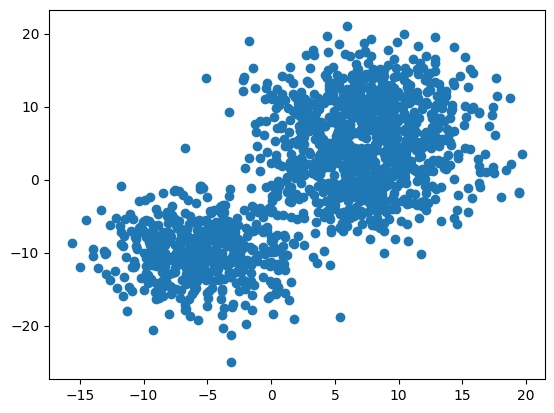

In [4]:
blobs2 = datasets.make_blobs(n_samples=1500, random_state=8, cluster_std=4)
X2,y2 = blobs2
plt.scatter(X2[:, 0], X2[:, 1])

## Fuzzy C-means clustering


In [5]:
from fcmeans import FCM  # need to install fuzzy-c-means

In [6]:
# You can switch from X to X2 to see the differences. X2 will have weaker associations as there is more dispersion in the data

data = X2 

In [7]:
fcm = FCM(n_clusters=3, max_iter=10)
fcm.fit(data)
weights = fcm.soft_predict(data)
labels = fcm.predict(data)

In [8]:
fcm.centers

array([[ -5.60185387, -10.20327543],
       [  6.58290188,  -0.01069775],
       [  8.13180616,   9.545515  ]])

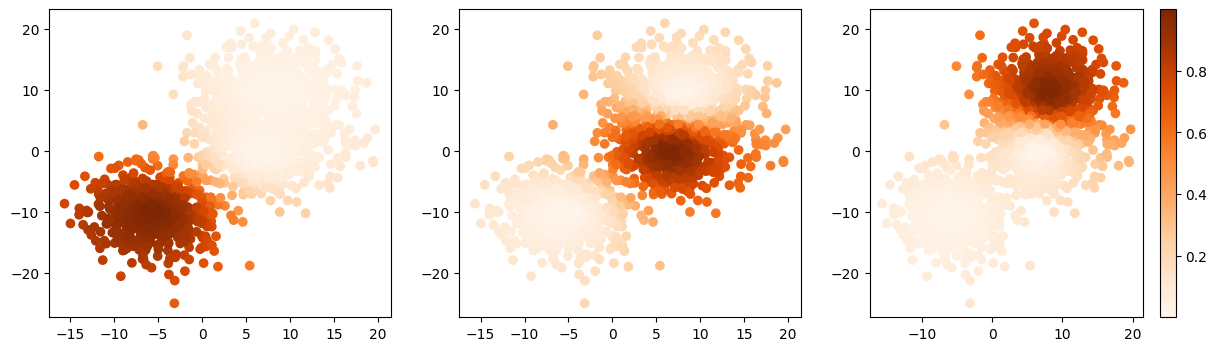

In [9]:
plt.rcParams['figure.figsize'] = [15, 4]

fig, axs = plt.subplots(1,3)

cm = plt.get_cmap('Oranges')
p0 = axs[0].scatter(data[:, 0], data[:, 1], c=weights[:,0], cmap=cm)
p1 = axs[1].scatter(data[:, 0], data[:, 1], c=weights[:,1], cmap=cm)
p2 = axs[2].scatter(data[:, 0], data[:, 1], c=weights[:,2], cmap=cm)

plt.colorbar(p2)

plt.show()

In [10]:
fcm = FCM(n_clusters=3, max_iter=10, m=5)
fcm.fit(data)
weights = fcm.soft_predict(data)

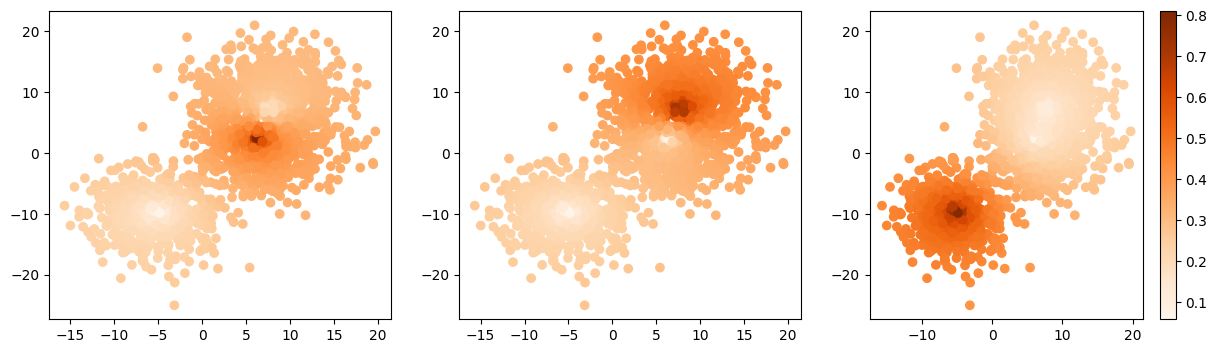

In [11]:
plt.rcParams['figure.figsize'] = [15, 4]

fig, axs = plt.subplots(1,3)

cm = plt.get_cmap('Oranges')
p0 = axs[0].scatter(data[:, 0], data[:, 1], c=weights[:,0], cmap=cm)
p1 = axs[1].scatter(data[:, 0], data[:, 1], c=weights[:,1], cmap=cm)
p2 = axs[2].scatter(data[:, 0], data[:, 1], c=weights[:,2], cmap=cm)

plt.colorbar(p2)

plt.show()

## Gaussian Mixture Modeling

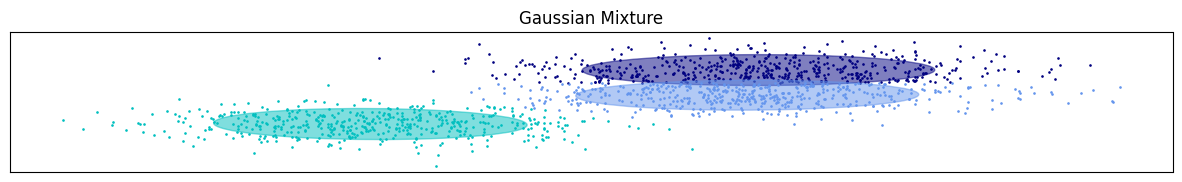

In [12]:
## Example modified from  https://scikit-learn.org/stable/auto_examples/mixture/plot_gmm.html#sphx-glr-auto-examples-mixture-plot-gmm-py


from sklearn import mixture


color_iter = itertools.cycle(["navy", "c", "cornflowerblue", "gold", "darkorange"])


def plot_results(X, Y_, means, covariances, index, title):
    splot = plt.subplot(2, 1, 1 + index)
    for i, (mean, covar, color) in enumerate(zip(means, covariances, color_iter)):
        v, w = linalg.eigh(covar)
        v = 2.0 * np.sqrt(2.0) * np.sqrt(v)
        u = w[0] / linalg.norm(w[0])
        # as the DP will not use every component it has access to
        # unless it needs it, we shouldn't plot the redundant
        # components.
        if not np.any(Y_ == i):
            continue
        plt.scatter(X[Y_ == i, 0], X[Y_ == i, 1], 0.8, color=color)

        # Plot an ellipse to show the Gaussian component
        angle = np.arctan(u[1] / u[0])
        angle = 180.0 * angle / np.pi  # convert to degrees
        ell = mpl.patches.Ellipse(mean, v[0], v[1], angle=180.0 + angle, color=color)
        ell.set_clip_box(splot.bbox)
        ell.set_alpha(0.5)
        splot.add_artist(ell)

    plt.xticks(())
    plt.yticks(())
    plt.title(title)



# Fit a Gaussian mixture with EM using 3 components

data = X2

gmm = mixture.GaussianMixture(n_components=3, covariance_type="full").fit(data)
plot_results(data, gmm.predict(data), gmm.means_, gmm.covariances_, 0, "Gaussian Mixture")
plt.rcParams['figure.figsize'] = [12, 12]
plt.show()

## Non-negative Matrix Factorization


In [13]:
path_to_export = "/Users/paul_gwu/code/data/MovieLensExport/" ## please replace with your own path!
duckdb.sql(f'''IMPORT DATABASE '{path_to_export}' ''') # parquet is a fast and efficient format
#Let's check that the data all loaded!
duckdb.sql('SHOW TABLES')

┌──────────────┐
│     name     │
│   varchar    │
├──────────────┤
│ date_dim     │
│ driver       │
│ driver2      │
│ genre_dim    │
│ links        │
│ movie_dim    │
│ movies       │
│ ratings      │
│ ratings_fact │
│ tags         │
│ user_dim     │
│ user_matrix  │
├──────────────┤
│   12 rows    │
└──────────────┘

In [14]:
duckdb.sql('SELECT * FROM ratings_fact LIMIT 10').df()

,userId,movieId,rating,timestamp,rating_date
0,1,1,4.0,964982703,2000-07-30
1,1,3,4.0,964981247,2000-07-30
2,1,6,4.0,964982224,2000-07-30
3,1,47,5.0,964983815,2000-07-30
4,1,50,5.0,964982931,2000-07-30
5,1,70,3.0,964982400,2000-07-30
6,1,101,5.0,964980868,2000-07-30
7,1,110,4.0,964982176,2000-07-30
8,1,151,5.0,964984041,2000-07-30
9,1,157,5.0,964984100,2000-07-30


In [15]:
query = '''
CREATE OR REPLACE TABLE rating_nmf AS
(
WITH likes AS
( SELECT * FROM ratings_fact WHERE rating >=4)

, top_regular_users AS
( SELECT COUNT(*) AS like_count, userId FROM likes GROUP BY userId HAVING like_count < 500 ORDER BY like_count DESC LIMIT 5000)

, top_liked_movies AS 
( SELECT COUNT(*) AS like_count, movieId FROM likes GROUP BY movieId ORDER BY like_count DESC LIMIT 1500)


SELECT 
 l.userId
 , l.movieId
 , l.rating
 , md.title
FROM
    likes l
INNER JOIN
    top_regular_users u
ON 
    u.userId = l.userId
INNER JOIN
    top_liked_movies m
ON 
    m.movieId = l.movieId
LEFT JOIN
    movie_dim md
ON 
    l.movieId = md.movieId
)
'''
duckdb.sql(query)
duckdb.sql('SELECT * FROM rating_nmf').df()


,userId,movieId,rating,title
0,1,1,4.0,Toy Story (1995)
1,1,3,4.0,Grumpier Old Men (1995)
2,6,5,5.0,Father of the Bride Part II (1995)
3,1,6,4.0,Heat (1995)
4,6,7,4.0,Sabrina (1995)
...,...,...,...,...
35307,592,364,5.0,"Lion King, The (1994)"
35308,594,364,5.0,"Lion King, The (1994)"
35309,596,364,4.0,"Lion King, The (1994)"
35310,602,364,4.0,"Lion King, The (1994)"


In [16]:

query = '''

WITH
driver AS (
        PIVOT rating_nmf
        ON  title 
        USING 
         COUNT(rating) AS movie
        GROUP BY userId
    )

SELECT * FROM driver ORDER BY userId
'''
driver = duckdb.sql(query).df()
driver

,userId,(500) Days of Summer (2009)_movie,10 Cloverfield Lane (2016)_movie,10 Things I Hate About You (1999)_movie,101 Dalmatians (1996)_movie,101 Dalmatians (One Hundred and One Dalmatians) (1961)_movie,12 Angry Men (1957)_movie,12 Years a Slave (2013)_movie,127 Hours (2010)_movie,1408 (2007)_movie,1984 (Nineteen Eighty-Four) (1984)_movie,"20,000 Leagues Under the Sea (1954)_movie",2001: A Space Odyssey (1968)_movie,2010: The Year We Make Contact (1984)_movie,21 (2008)_movie,21 Grams (2003)_movie,21 Jump Street (2012)_movie,22 Jump Street (2014)_movie,25th Hour (2002)_movie,27 Dresses (2008)_movie,28 Days (2000)_movie,28 Days Later (2002)_movie,28 Weeks Later (2007)_movie,300 (2007)_movie,"39 Steps, The (1935)_movie",3:10 to Yuma (2007)_movie,"40-Year-Old Virgin, The (2005)_movie","400 Blows, The (Les quatre cents coups) (1959)_movie",50 First Dates (2004)_movie,50/50 (2011)_movie,8 1/2 (8½) (1963)_movie,8 Mile (2002)_movie,9 (2009)_movie,A.I. Artificial Intelligence (2001)_movie,About Schmidt (2002)_movie,About Time (2013)_movie,About a Boy (2002)_movie,"Abyss, The (1989)_movie",Ace Ventura: Pet Detective (1994)_movie,Ace Ventura: When Nature Calls (1995)_movie,Across the Universe (2007)_movie,Adaptation (2002)_movie,Addams Family Values (1993)_movie,"Addams Family, The (1991)_movie",Adventures in Babysitting (1987)_movie,"Adventures of Baron Munchausen, The (1988)_movie","Adventures of Buckaroo Banzai Across the 8th Dimension, The (1984)_movie","Adventures of Priscilla, Queen of the Desert, The (1994)_movie","African Queen, The (1951)_movie",Air Force One (1997)_movie,Airplane II: The Sequel (1982)_movie,Airplane! (1980)_movie,Akira (1988)_movie,Aladdin (1992)_movie,Alice in Wonderland (1951)_movie,Alice in Wonderland (2010)_movie,Alien (1979)_movie,Alien: Resurrection (1997)_movie,Aliens (1986)_movie,Alien³ (a.k.a. Alien 3) (1992)_movie,All About Eve (1950)_movie,All About My Mother (Todo sobre mi madre) (1999)_movie,All the President's Men (1976)_movie,Almost Famous (2000)_movie,Amadeus (1984)_movie,"Amazing Spider-Man, The (2012)_movie","Amelie (Fabuleux destin d'Amélie Poulain, Le) (2001)_movie",American Beauty (1999)_movie,American Gangster (2007)_movie,American Graffiti (1973)_movie,American History X (1998)_movie,American Hustle (2013)_movie,American Pie (1999)_movie,American Pie 2 (2001)_movie,"American President, The (1995)_movie",American Psycho (2000)_movie,American Sniper (2014)_movie,American Splendor (2003)_movie,"American Tail, An (1986)_movie","American Werewolf in London, An (1981)_movie","American in Paris, An (1951)_movie",Amistad (1997)_movie,Amores Perros (Love's a Bitch) (2000)_movie,Analyze This (1999)_movie,Anchorman: The Legend of Ron Burgundy (2004)_movie,And Your Mother Too (Y tu mamá también) (2001)_movie,Anger Management (2003)_movie,Animal House (1978)_movie,"Animatrix, The (2003)_movie",Annie Hall (1977)_movie,Ant-Man (2015)_movie,Antz (1998)_movie,"Apartment, The (1960)_movie",Apocalypse Now (1979)_movie,Apocalypto (2006)_movie,Apollo 13 (1995)_movie,Arachnophobia (1990)_movie,Argo (2012)_movie,"Aristocats, The (1970)_movie",Arlington Road (1999)_movie,Armageddon (1998)_movie,Army of Darkness (1993)_movie,Arrival (2016)_movie,"Arrival, The (1996)_movie",Arsenic and Old Lace (1944)_movie,As Good as It Gets (1997)_movie,Atlantis: The Lost Empire (2001)_movie,Austin Powers in Goldmember (2002)_movie,Austin Powers: International Man of Mystery (1997)_movie,Austin Powers: The Spy Who Shagged Me (1999)_movie,Avatar (2009)_movie,"Avengers, The (2012)_movie",Avengers: Age of Ultron (2015)_movie,Avengers: Infinity War - Part I (2018)_movie,"Aviator, The (2004)_movie",Awakenings (1990)_movie,Babe (1995)_movie,Babe: Pig in the City (1998)_movie,Babel (2006)_movie,Baby Driver (2017)_movie,Back to the Future (1985)_movie,Back to the Future Part II (1989)_movie,Back to the Future Part III (1990)_movie,Backdraft (1991)_movie,Bad Boys (1995)_movie,Bad Santa (2003)_movie,Badlands (1973)_movie,Bambi (1942)_mov

In [17]:
features = [i for i in driver.columns if 'movie' in i]

X = driver[features]

nmf = NMF(n_components = 25, random_state=42)
W = nmf.fit_transform(X)
H = nmf.components_

print(W.shape, H.shape)


(601, 25) (25, 1500)


In [18]:
def print_top_movies(nmf, topic_no, topn=10):
    top_movies = Counter()
    for i, j in zip(features, nmf.components_[topic_no]):
        top_movies[i] = j

    top_movie_list = []

    for k,v in top_movies.most_common(topn):
        top_movie_dict = {}
        top_movie_dict['movie'] = k.replace('_movie','')
        top_movie_dict['component'] = v
        top_movie_list.append(top_movie_dict)
    return pd.DataFrame.from_dict(top_movie_list)


In [19]:
print_top_movies(nmf, 0)

,movie,component
0,Star Wars: Episode V - The Empire Strikes Back...,6.558972
1,Raiders of the Lost Ark (Indiana Jones and the...,6.507272
2,Star Wars: Episode IV - A New Hope (1977),6.475236
3,Terminator 2: Judgment Day (1991),6.043765
4,Star Wars: Episode VI - Return of the Jedi (1983),5.848132
5,Indiana Jones and the Last Crusade (1989),5.388552
6,"Terminator, The (1984)",4.900335
7,Jurassic Park (1993),4.203388
8,Back to the Future (1985),4.188199
9,Die Hard (1988),3.985763


In [20]:
print_top_movies(nmf, 1)

,movie,component
0,"Lord of the Rings: The Fellowship of the Ring,...",6.915364
1,"Lord of the Rings: The Return of the King, The...",6.873026
2,"Lord of the Rings: The Two Towers, The (2002)",6.570071
3,Shrek (2001),2.748057
4,Pirates of the Caribbean: The Curse of the Bla...,2.331900
5,"Incredibles, The (2004)",2.099017
6,"Monsters, Inc. (2001)",1.935638
7,Gladiator (2000),1.753714
8,Toy Story (1995),1.591364
9,"Sixth Sense, The (1999)",1.530047


In [21]:
print_top_movies(nmf, 7)

,movie,component
0,Chinatown (1974),2.357742
1,"Godfather, The (1972)",2.256672
2,Rear Window (1954),2.218715
3,One Flew Over the Cuckoo's Nest (1975),2.210855
4,Psycho (1960),2.165976
5,Casablanca (1942),2.136412
6,North by Northwest (1959),2.060707
7,Citizen Kane (1941),1.988195
8,Dr. Strangelove or: How I Learned to Stop Worr...,1.963480
9,Taxi Driver (1976),1.920688


In [22]:
print_top_movies(nmf, 16)

,movie,component
0,Anchorman: The Legend of Ron Burgundy (2004),0.677284
1,Big (1988),0.622429
2,Napoleon Dynamite (2004),0.618377
3,Willy Wonka & the Chocolate Factory (1971),0.617557
4,"O Brother, Where Art Thou? (2000)",0.589102
5,"Christmas Story, A (1983)",0.584345
6,This Is Spinal Tap (1984),0.562975
7,High Fidelity (2000),0.554499
8,Batman Begins (2005),0.545516
9,Edward Scissorhands (1990),0.540933


In [25]:
print_top_movies(nmf, 4)

,movie,component
0,Mary Poppins (1964),1.719593
1,Finding Nemo (2003),1.685866
2,Shrek (2001),1.555735
3,Harry Potter and the Chamber of Secrets (2002),1.538074
4,Pretty Woman (1990),1.518238
5,My Fair Lady (1964),1.517887
6,Beauty and the Beast (1991),1.495427
7,"Lion King, The (1994)",1.425380
8,Singin' in the Rain (1952),1.378428
9,"Sound of Music, The (1965)",1.376027


In [35]:
print_top_movies(nmf, 14)

,movie,component
0,"Avengers, The (2012)",1.529198
1,Up (2009),1.409783
2,Iron Man (2008),1.346995
3,Guardians of the Galaxy (2014),1.323021
4,"Dark Knight, The (2008)",1.199954
5,WALL·E (2008),1.195254
6,Avatar (2009),1.052902
7,"Dark Knight Rises, The (2012)",0.985740
8,"Matrix, The (1999)",0.956059
9,Iron Man 2 (2010),0.950647


In [36]:
print_top_movies(nmf, 12)

,movie,component
0,Monty Python and the Holy Grail (1975),0.406992
1,Monty Python's Life of Brian (1979),0.397262
2,Monty Python's And Now for Something Completel...,0.386365
3,Road to Perdition (2002),0.384780
4,Airplane! (1980),0.379634
5,"Lock, Stock & Two Smoking Barrels (1998)",0.378154
6,One Flew Over the Cuckoo's Nest (1975),0.377729
7,"Grand Day Out with Wallace and Gromit, A (1989)",0.372992
8,Wallace & Gromit: The Wrong Trousers (1993),0.371265
9,Indiana Jones and the Temple of Doom (1984),0.370788
